As highlighted in the [data pre-processing article](/posts/medalla-data_prep), the proportion of validators who successfully submit attestations is an important metric. Validators representing at least ⅔ of the staked ether need to attest to any given block before it can be finalised (along with all its ancestor blocks). The fraction of staked ether which *does* attest when called to do so in any given slot is called the *participation rate*. In general, a high participation rate is a signal of a healthy network. Conversely if the participation rate drops significantly below 100%, this may be a result of a range of different problems, such as:

- a bug in a client preventing validators running that software from attesting at the right time;
- the network becoming partitioned such that different groups of validators cannot talk to one another;
- interoperability problems between clients due to incompatible interpretations of the spec;
- excessive computational load on validators (or underpowered validator hardware);
- excessive bandwith usage or network latency;
- \[and many others\].

Such problems might be caused by implentation bugs, attacks by adversaries or, most seriously of all, fundamental flaws in the design of the eth2 spec. Identifying them in the testnet data is therefore extremely important, since they could hint at serious risks for validators who will later be putting valuable assets (ether) at risk.

However, in the Medalla network there is no real value is at stake. This leads to another possible explanation for low participation rates:

- users are not incentivised to participate, and may not bother to run their validators consistently, or at all.

Moreover, users who run into difficulty in using client software or simply lose interest in the project are likely simply to "walk away" from the network rather than using the *voluntary exit* procedure defined in the spec. But before getting into that, let's first take a look at how the make-up of the validator set varies over the course of the dataset. As before, we start by getting pulling out some of the data we need from `chaind`:

In [1]:
# imports
import time

import psycopg2
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import pandas as pd
from IPython.display import display, clear_output

In [2]:
# open/restart connection to chaind database
try:
    cursor.close()
    connection.close()
except:
    pass

connection = psycopg2.connect(user="chain", host="127.0.0.1", database="chain", password="medalla")
cursor = connection.cursor()

In [3]:
# get info about dataset and validators

cursor.execute("SELECT MAX(f_slot) FROM t_blocks")
latest_slot = cursor.fetchone()[0]
n_slots = latest_slot + 1
n_epochs = (n_slots - (n_slots % 32)) // 32

cursor.execute("SELECT f_activation_eligibility_epoch, f_activation_epoch, f_exit_epoch, f_slashed, "
               "f_first_attested_epoch, f_latest_attested_epoch FROM t_validators ORDER BY f_index")
result = cursor.fetchall()
validators = [{"activation_eligibility_epoch": r[0],
               "activation_epoch"            : r[1],
               "exit_epoch"                  : r[2],
               "slashed"                     : r[3],
               "first_attestation"           : r[4],
               "latest_attestation"          : r[5]} for r in result]

## Validator Life Cycle
Validators on the beacon chain progress through several states, starting as deposits of at least 32 ETH on the eth1 chain (or the Görli testnet in the case of Medalla). These deposits are processed by beacon chain nodes, becoming eligible for activation either immediately (if there aren't too many validators trying to join at once), or after they reach the front of an activation queue. Once activated, each validator is assigned to one committee each epoch, and expected to produce an attestation. Validators may also be nominated as block proposers.

If a validator no longer wishes to participate in the beacon chain they may initiate a *voluntary exit*. If there are many validators attempting to exit the validator set at the same time then again, they will form a queue, and will be required to continue submitting attestations until they reach the front of the queue. If a validator's balance falls below 16 ETH due to penalties for poor performance (such as *inactivity leak*), they will also exit the validator set.

Finally, if a validator provably contradicts themselves — for example by attesting to two different blocks for the same slot — they may be slashed, instantly losing a large proportion of their staked ether and being ejected from the validator set.

At each epoch therefore we can categorise validators into four types:
1. **waiting**: validators who have had their deposits from the eth1 chain processed, and are in a queue to join the active validator set
2. **active**: validators who are required to produce an attestation each epoch
3. **exited**: validators who have left the validator set, either because they made a voluntary withdrawal, or because their balance leaked through inactivity to the point where they were ejected from the validator set (this happens if the validator's balance drops below 16 ETH)
4. **slashed**: validators who were ejected from the validator set for breaking protocol rules (e.g. contradicting themselves by attesting to multiple blocks for the same slot)

Validators who have exited or been slashed cannot rejoin the activation queue or start attesting again (although in future they will be able to withdraw previously staked ether to create a new valdator, if they choose).

In [4]:
# get validator status by epoch - waiting, active, exited, slashed
start_time = time.time()

waiting_count = [0] * n_epochs
active_count  = [0] * n_epochs
slashed_count = [0] * n_epochs
exited_count  = [0] * n_epochs

for epoch in range(n_epochs):
    for validator in validators:
        if epoch >= validator["activation_eligibility_epoch"] and epoch < validator["activation_epoch"]:
            waiting_count[epoch] += 1
        elif validator["exit_epoch"] != -1 and epoch >= validator["exit_epoch"] :
            if validator["slashed"]:
                slashed_count[epoch] += 1
            else:
                exited_count[epoch] += 1
        elif epoch >= validator["activation_epoch"]:
            active_count[epoch] += 1

    seconds = time.time() - start_time
    elapsed = time.strftime("%H:%M:%S",time.gmtime(seconds))
    left = time.strftime("%H:%M:%S",time.gmtime(seconds * ((n_epochs) / (epoch+1)-1)))
    percentage = 100*(epoch+1)/n_epochs
    print(f"epoch {epoch} of {n_epochs-1} ({percentage:.2f}%) / {elapsed} elapsed / {left} left", end='\r')

print(f"completed in {elapsed}" + ' ' * 50)
            
            
status_data = pd.DataFrame({'waiting': waiting_count, 'active': active_count,
                            'exited': exited_count, 'slashed': slashed_count})

completed in 00:06:22                                                  


The chart below shows the evolution of each of these categories of validator. We can see at genesis that almost the entire validator set is composed of *active* validators — those who submitted their deposits prior to genesis. During most of the period the active validator set grows linearly as the queue of *waiting* validators is processed.

The exception is a short period around epoch 3000 when a number of validators were slashed, the validator queue (represented in orange) was emptied and the active set stopped growing. This was due to the [roughtime incident](https://medium.com/prysmatic-labs/eth2-medalla-testnet-incident-f7fbc3cc934a), which will be explored in more detail in the next notebook. A small sliver of non-slashed exited validators also grows gradually throughout the dataset, most like due to users testing the *voluntary exit* procedure.

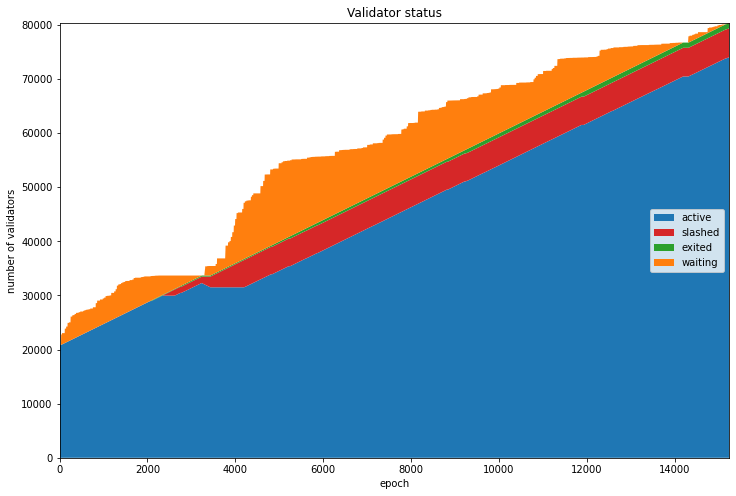

In [5]:
# draw validator status stacked area plot
fig=plt.figure(figsize=(12,8))
plt.stackplot(range(len(status_data.index)), status_data['active'], status_data['slashed'],
              status_data['exited'], status_data['waiting'],labels=['active','slashed','exited','waiting'],
              colors=['tab:blue','tab:red','tab:green','tab:orange'])
plt.legend(loc='right')
plt.margins(0,0)
plt.title('Validator status')
plt.xlabel('epoch')
plt.ylabel('number of validators')
plt.show()

## Effective Balance
Eth2 uses a concept of *effective balance* to simplify protocol calculations. While validators' actual balances will generally grow or leak very gradually according to their participation, the effective balance can only take integer values, and changes according to a hysteresis function to prevent it changing too frequently.

We can confirm that the "exited" validators from the chart above is composed exclusively of validators who have triggered a voluntary exit, rather than inactivity leak causing their balances to fall below 16 ETH, because the lowest effective balance of any validator in this group is 30 ETH, as calculated below.

Looking more widely at the effective balances of the validators, we find that among validators who have activated but not been slashed, the minimum effective balance is also 30 ETH, while the maximum effective balance is the protocol-imposed limit of 32 ETH. Meanwhile a small number of validators have been quite severely slashed. This can be seen in the distributions of effective balances for both slashed and non-slashed validators plotted below.

Given the very limited variation in effective balance amongst active validators in this dataset, we will weight validators equally in the remaining analysis. This will simplify the analysis at the cost of slight errors in calculations of participation rates.

Minimum exited validator effective balance: 30 ETH
Non-slashed validator balance (min, max): (30, 32) ETH
Slashed validator balance (min, max): (15, 32) ETH


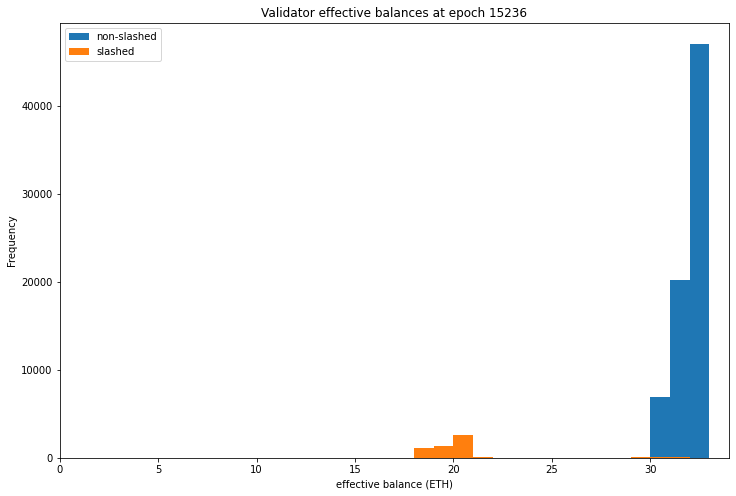

In [6]:
# show effective balances

cursor.execute(f"SELECT MIN(f_effective_balance) FROM t_validator_balances "
               f"WHERE f_validator_index IN "
               f"(SELECT f_index FROM t_validators WHERE f_exit_epoch != -1 AND NOT f_slashed)"
               f"AND f_epoch = {n_epochs-1}")

min_balance = cursor.fetchone()[0] * 10**-9
print(f"Minimum exited validator effective balance: {int(min_balance)} ETH")

cursor.execute(f"SELECT f_effective_balance FROM t_validator_balances WHERE f_validator_index IN"
               f"(SELECT f_index FROM t_validators WHERE NOT f_slashed  AND f_activation_epoch != -1)"
               f"AND f_epoch = {n_epochs-1}")
eff_balances = pd.Series([b[0]*10**-9 for b in cursor.fetchall()], name='non-slashed')

cursor.execute(f"SELECT f_effective_balance FROM t_validator_balances WHERE f_validator_index IN"
               f"(SELECT f_index FROM t_validators WHERE f_slashed)"
               f"AND f_epoch = {n_epochs-1}")
eff_balances_slashed = pd.Series([b[0]*10**-9 for b in cursor.fetchall()], name='slashed')

print(f"Non-slashed validator balance (min, max): "
      f"({int(eff_balances.min())}, {int(eff_balances.max())}) ETH")
print(f"Slashed validator balance (min, max): "
      f"({int(eff_balances_slashed.min())}, {int(eff_balances_slashed.max())}) ETH")

fig=plt.figure(figsize=(12,8))
eff_balances.plot.hist(bins=range(0,35))
eff_balances_slashed.plot.hist(bins=range(0,35))
plt.legend(loc='upper left')
plt.xlabel('effective balance (ETH)')
plt.title(f"Validator effective balances at epoch {n_epochs-1}")
plt.xlim(0,34);

## Types of Non-Participating Validator
We'll now look at whether each active validator managed to attest successfully, and have their attestations included into the canonical chain. If their attestations weren't included, we can use the information from each validator's `first_attestated_epoch` and `latest_attestated_epoch`, which we calculated in [data processing](/posts/medalla-data-prep) to have a guess at *why* the attestation was missed. We use the following definitions:
1. `success_count`: the number of attestations in the epoch that where successfully included in the canonical chain
2. `absent_count` : the number of scheduled attestations from validators who did not have any successful attestations in the whole dataset — we think of these validators as *absent* because they never showed up at all
3. `dormant_count`: the number of scheduled attestations from validators who have not *yet* made a successful attestations (but they did later in the dataset) — we think of these as *dormant* validators who were not ready to attest when their `activation_epoch` hit (perhaps they overslept?)
4. `abandoned_count`: the number of scheduled attestations from validators who have no later successful attestations in the dataset (these are perhaps validators who lost interest in the testnet and simply *abandoned* their validator(s) without initiating the proper exit procedure)
5. `missed_count`: any other scheduled attestations which were not made each epoch.

As stated above these categories are all just guesses, based on each validator's behaviour. These categorisations are partly based on the assumption that with no real value at stake on the Medalla testnet, some people will make deposits for validators that they never bother to fire up (*absent*), some may not prepare in advance of activation and therefore be late (*dormant*), and still others may not bother to pick up their validator if it falls over, or they have no further interest in participating (*abandoned*).

This is not meant pejoratively! My own validator would show up as *dormant* for a few epochs, since I hadn't factored in the time needed to compile and run the Lighthouse beacon chain client before Medalla's genesis time (**blushes**). Rather it is an illustration of the difficulty inherent in trying to test an economically driven consensus/finality mechanism without economic incentives. The code below totals up each of these categories of validator on a per-epoch basis:

In [7]:
# count and categorise attestations

# if the attestation is missed and the validator has not yet made any attestations, it is considered dormant
# if the attestation is missed and the validator makes no future attestations, it is considered abandoned
# if the attestation is missed and the validator makes no successful attestations at all, it is considered absent

start_time = time.time()
last_update = 0

empty = [0] * n_epochs
success_count   = empty.copy()
absent_count    = empty.copy()
dormant_count   = empty.copy()
abandoned_count = empty.copy()
missed_count    = empty.copy()

for slot in range(n_epochs * 32):
    cursor.execute(f"SELECT f_validator_index, f_performance, f_effectiveness "
                   f"FROM t_validator_performance WHERE f_slot = {slot}")
    result = cursor.fetchone()
    validator_indices  = result[0]
    performance        = result[1]
    effectiveness      = result[2]
    
    epoch = slot // 32
    for position, val_index in enumerate(validator_indices):
        if performance[position] != -1:
            success_count[epoch]   += 1
        elif validators[val_index]["latest_attestation"] == -1:
            absent_count[epoch]    += 1
        elif epoch < validators[val_index]["first_attestation"]:
            dormant_count[epoch]   += 1
        elif epoch > validators[val_index]["latest_attestation"]:
            abandoned_count[epoch] += 1
        else:
            missed_count[epoch]    += 1

    t = time.time()
    if t - last_update > 0.1:
        last_update = t
        seconds = t - start_time
        elapsed = time.strftime("%H:%M:%S",time.gmtime(seconds))
        left = time.strftime("%H:%M:%S",time.gmtime(seconds * ((latest_slot+1) / (slot+1)-1)))
        percentage = 100*(slot+1)/(latest_slot+1)
        print(f"epoch {epoch} of {latest_slot//32} ({percentage:.2f}%) / "
              f"{elapsed} elapsed / {left} left", end='\r')

clear_output()
print(f"completed in {elapsed}.")

completed in 00:12:51.


## Participation trends
We can now take a look at how the network performed, in terms of the percentage of validators who successfully attested each epoch (the *participation rate*). We can also look that the breakdown of validators who failed to attest during a given epoch according to whether they have ever previously successfully attested, or will successfully attest at some future point (using the cateogires *absent*, *dormant* and *abandoned* defined above). This information is shown graphicaly in the stacked validator participation chart below.

The biggest feature of this chart is clearly the enormous growth in missed attestations (orange) which occurs during/after the [roughtime incident](https://medium.com/prysmatic-labs/eth2-medalla-testnet-incident-f7fbc3cc934a). The participation rate even drops to zero for at least one epoch, raising an interesting question about the security of the network at this point. This incident and the network stress it caused will be the subject of the [next article](/posts/medalla-network-stress).

The chart shows a fairly consistent slice of the validator set was composed of absent validators who deposited but never participated (in purple). The dormant slice (green) varied more, and interestingly we can see little ramps where a series of new validators were activated but were dormant for some time. This is likely to be the result of testnet whales joining with hundreds of validators without being ready. The number of dormant validators grows significantly during/after the roughtime incident, as new validators were unable to sync their clients to the beacon chain.

The slice of abandoned validators (red) grows gradually throughout the dataset, and widens significantly during and after roughtime incident. It also grows much faster towards the end of the dataset. This may be due to large numbers of users switching off their validators in preparation for mainnet, or because they feel they have already devoted enough time and energy to the testnet for their own needs. Information about how to initiate a voluntary exit has been less widely shared than information on how to join the network (such as [Somer Esat](https://twitter.com/SomerEsat)'s excellent guides: [Prysm](https://medium.com/@SomerEsat/guide-to-staking-on-ethereum-2-0-ubuntu-medalla-prysm-4d2a86cc637b), [Lighthouse](https://medium.com/@SomerEsat/guide-to-staking-on-ethereum-2-0-ubuntu-medalla-lighthouse-c6f3c34597a8), [Teku](https://medium.com/@SomerEsat/guide-to-staking-on-ethereum-2-0-ubuntu-medalla-teku-170e2c52bd23), [Nimbus](https://medium.com/@SomerEsat/guide-to-staking-on-ethereum-2-0-ubuntu-medalla-nimbus-5f4b2b0f2d7c)), so some may not even realise that a formal exit procedure is needed.

Indeed, [evidence from forums](https://www.reddit.com/r/ethstaker/comments/jdkgo7/are_we_still_trying_to_run_medalla/?utm_source=share&utm_medium=web2x&context=3) suggests that some users are unaware of how or why to use the protocol voluntary exit procedure. This effect is therefore probably part of the cause for the Medalla participation rate dropping [to very low levels](https://hackmd.io/@benjaminion/wnie2_201018#Testnets) in recent days.

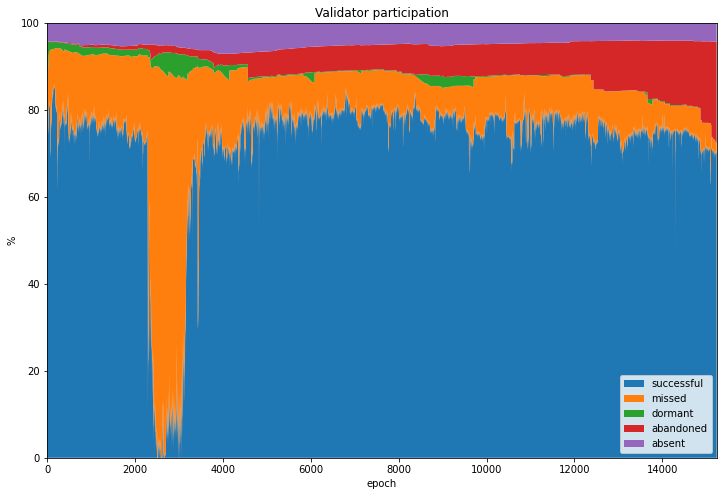

In [8]:
# participation rate stacked area plots

participation_data = pd.DataFrame({'successful': success_count,
                                   'missed': missed_count,
                                   'absent': absent_count,
                                   'dormant': dormant_count,
                                   'abandoned': abandoned_count})

perc_participation_data = participation_data.divide(participation_data.sum(axis=1), axis=0) * 100

fig=plt.figure(figsize=(12,8))
plt.stackplot(range(len(perc_participation_data.index)),
              perc_participation_data['successful'],
              perc_participation_data['missed'],
              perc_participation_data['dormant'],
              perc_participation_data['abandoned'],
              perc_participation_data['absent'],
              labels=['successful','missed','dormant','abandoned','absent'])
plt.legend(loc='lower right')
plt.margins(0,0)
plt.title('Validator participation')
plt.xlabel('epoch')
plt.ylabel('%')
plt.show()

## Excluding Dormant, Absent and Abandoned Validators
Using our categories for unresponsive validators (dormant, absent, abandoned) we can also take a look at what the network might look like without them. This makes sense, since in a value-bearing mainnet deployment, such validator behaviour would become economically costly.

At an ETH price of USD 375, each validator will require USD 12,000 to be locked for participation. If these validators are ignored or abandoned by their owners, they will incur opportunity cost for missed validator rewards, and inactivity leakage cost for failure to attestations, in addition to the underlying cost of capital. With this in mind, the very existence of these types of non-live validator is not expected, unless such validator behaviour is somehow caused by as-yet unidentified client bugs or protocol flaws.

The graphs created above have been repeated, but this time only `success_count` and `missed_count` are used in the calculation of the participation rate. Now the mean participation rate jumps by 10-13 percentage points, reaching  89% with zero sub-⅔ particpation epochs from 5000 onwards.

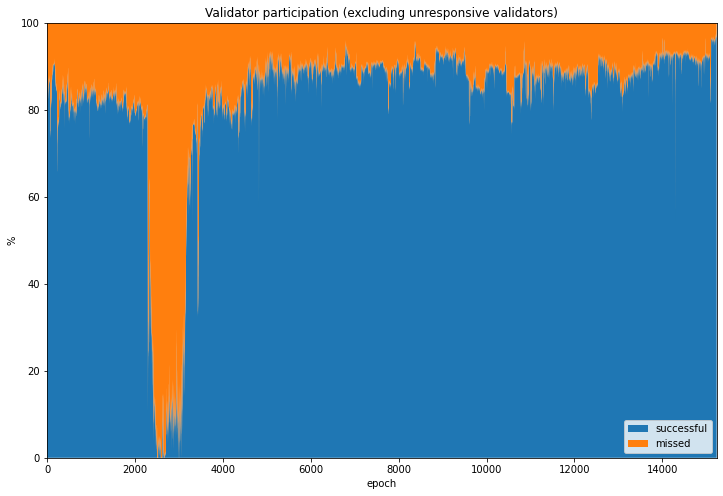

In [9]:
# participation rate statistics and stacked area plots (excluding unresponsive validators)

reduced_participation_data = pd.DataFrame({'successful': success_count, 'missed': missed_count})

perc_reduced_participation_data = participation_data.divide(reduced_participation_data.sum(axis=1), axis=0) * 100

fig=plt.figure(figsize=(12,8))
plt.stackplot(range(len(perc_reduced_participation_data.index)),
              perc_reduced_participation_data['successful'],
              perc_reduced_participation_data['missed'],
              labels=['successful','missed'])
plt.legend(loc='lower right')
plt.margins(0,0)
plt.title('Validator participation (excluding unresponsive validators)')
plt.xlabel('epoch')
plt.ylabel('%')
plt.show()

## Participation statistics
Another way of looking at the data is to consider the statistical distribution of participation rates by epoch. This can give us a better sense of what proportion of epochs fall above any particular partcipation rate. Clearly the key rate of greatest significance is ⅔, but a sense of the shape of the overall distribution may tell us more than this number alone.

In the statistics and plots below we find that over 90% of epochs were above ⅔ participation. This proportion increases slightly if we ignore unresponsive (i.e. absent, dormant or abandoned) validators. We know that the previously mentioned roughtime incident was responsible for a prolonged periods of non-finalisation, and this will be explored in the next notebook. To take a look at how the network has performed since the resolution of this instance, the analysis is repeated in the second row, starting from epoch 5000.

From epoch 5000 onwards, we find that 99.8% of epochs reached the ⅔ quorum. If we exclude unresponsive validators, this reaches 100%.

participation rate statistics by epoch

all data                                     excl. unresponsive validators
--------                                     -----------------------------
 mean  72.511856                              mean   82.982816
  std  15.642732                               std   18.094975
  min   0.000000                               min    0.000000
  50%  76.511776                               50%   88.324085
  max  86.428814                               max  100.000000
epochs over 2/3 participation: 92.4%         epochs over 2/3 participation: 93.5%
                                             
                                             
epoch 5000 onwards                           epoch 5000 onwards, excl. unresponsive validators
------------------                           -------------------------------------------------
 mean  76.986188                              mean  89.459441
  std   2.965273                               std   2.821643
  min  

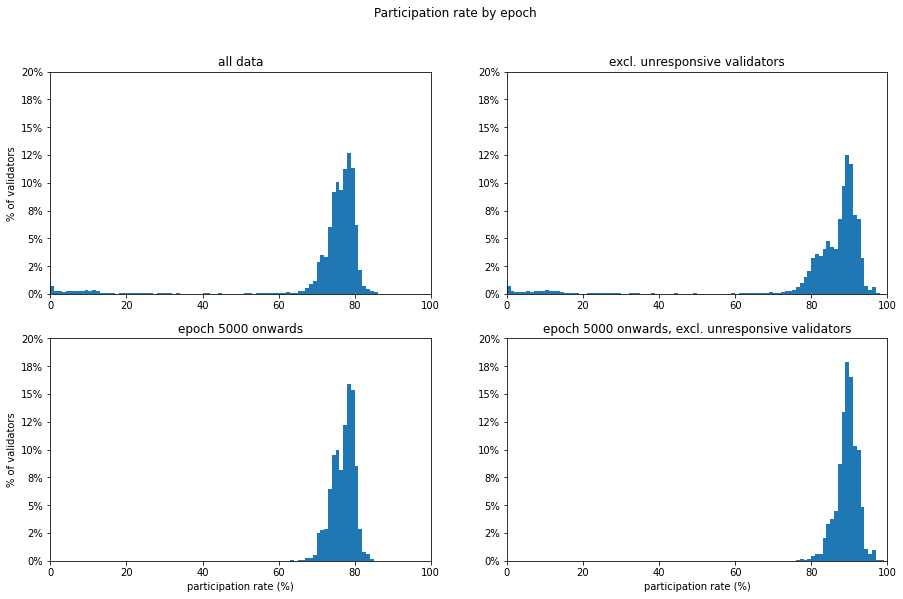

In [13]:
# participation rate statistics - include/exclude roughtime, non-live validators

fig, axs = plt.subplots(2, 2, figsize=(15,9))
fig.suptitle('Participation rate by epoch')

print("participation rate statistics by epoch\n")

col1 = []
col2 = []
col1.append("all data")
col1.append("--------")
stats = perc_participation_data['successful'].describe().loc[['mean','std','min','50%','max']]
col1 += stats.reset_index().to_string(header=None, index=None).split('\n')
quorate = 100 * len(perc_participation_data[perc_participation_data['successful'] > 200/3]) / n_epochs
col1.append(f"epochs over 2/3 participation: {quorate:.1f}%")
col1 += ['','']

col2.append("excl. unresponsive validators")
col2.append("-----------------------------")
stats = perc_reduced_participation_data['successful'].describe().loc[['mean','std','min','50%','max']]
col2 += stats.reset_index().to_string(header=None, index=None).split('\n')
quorate = 100 * len(perc_reduced_participation_data[perc_reduced_participation_data['successful'] > 200/3]) / n_epochs
col2.append(f"epochs over 2/3 participation: {quorate:.1f}%")
col2 += ['','']

col1.append("epoch 5000 onwards")
col1.append("------------------")
after_roughtime = perc_participation_data['successful'].iloc[range(5000,n_epochs)]
stats = after_roughtime.describe().loc[['mean','std','min','50%','max']]
col1 += stats.reset_index().to_string(header=None, index=None).split('\n')
quorate = 100 * len(after_roughtime[after_roughtime > 200/3]) / (n_epochs - 5000)
col1.append(f"epochs over 2/3 participation: {quorate:.1f}%")

col2.append("epoch 5000 onwards, excl. unresponsive validators")
col2.append("-------------------------------------------------")
after_roughtime_reduced = perc_reduced_participation_data['successful'].iloc[range(5000,n_epochs)]
stats = after_roughtime_reduced.describe().loc[['mean','std','min','50%','max']]
col2 += stats.reset_index().to_string(header=None, index=None).split('\n')
quorate = 100 * len(after_roughtime_reduced[after_roughtime_reduced > 200/3]) / (n_epochs - 5000)
col2.append(f"epochs over 2/3 participation: {quorate:.1f}%")

for row, text in enumerate(col1):
    print(text.ljust(45,' ') + col2[row])

perc_participation_data['successful'].plot.hist(density=True, bins=range(0,101), ax=axs[0,0])
axs[0, 0].set_title('all data')
axs[0, 0].set_ylabel('% of validators')
axs[0, 0].set_xlim(0,100)
axs[0, 0].set_ylim(0,0.2)
axs[0, 0].yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0));

perc_reduced_participation_data['successful'].plot.hist(density=True, bins=range(0,101), ax=axs[0,1])
axs[0, 1].set_title('excl. unresponsive validators')
axs[0, 1].set_ylabel('')
axs[0, 1].set_xlim(0,100)
axs[0, 1].set_ylim(0,0.2)
axs[0, 1].yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0));

after_roughtime.plot.hist(density=True, bins=range(0,101), ax=axs[1,0])
axs[1, 0].set_title('epoch 5000 onwards')
axs[1, 0].set_xlabel('participation rate (%)')
axs[1, 0].set_ylabel('% of validators')
axs[1, 0].set_xlim(0,100)
axs[1, 0].set_ylim(0,0.2)
axs[1, 0].yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0));

after_roughtime_reduced.plot.hist(density=True, bins=range(0,101), ax=axs[1,1])
axs[1, 1].set_title('epoch 5000 onwards, excl. unresponsive validators')
axs[1, 1].set_xlabel('participation rate (%)')
axs[1, 1].set_ylabel('')
axs[1, 1].set_xlim(0,100)
axs[1, 1].set_ylim(0,0.2)
axs[1, 1].yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0));

## Genesis
One of the difficulties encountered with Medalla was at genesis, it took longer than may have been expected before the participation rate reached the ⅔ threshold for finality. This can be seen in the area plot below showing the first 50 epochs. Initially a large proportion of validators are *dormant* and the ⅔ threshold is not reached until the 7th epoch. Even if we exclude the subset of *absent* validators, we do not see that finality would have been reached any sooner.

This was a pattern that was repeated for the "genesis rehearsal" *Spadina* testnet, which was hindered by [client release and configuration issues](https://blog.ethereum.org/2020/10/01/eth2-quick-update-no-18/), taking even longer to reach finality. Finally, the *Zinken* genesis rehearsal appears to have gone smoothly, finalising at its [second epoch](https://twitter.com/q9fmz/status/1315630137719877632?s=20). But the genesis experiences for both Medalla and Spadina demonstrate that the launch process in particular has the potential for hiccups. The proposed [lengthening](https://hackmd.io/@benjaminion/wnie2_200808) of the genesis delay should go some way to preventing these problems for mainnet launch, and should be accompanied by guidance that validators should have their beacon nodes up and running well in advance of launch time.

On the positive side, the actual penalties for non-participating validators (known as inactivity leak) are not severe, as long as the period of non-finality is reasonably short. A repeat of Medalla's ~1 hour wait for finality would not be a serious problem.

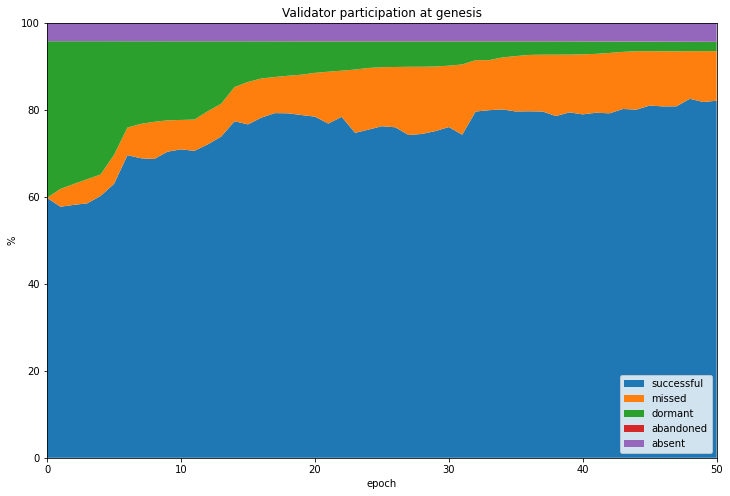

epoch,All data,Excluding absent
0,59.8,62.4
1,57.7,60.3
2,58.2,60.7
3,58.5,61.1
4,60.2,62.9
5,63.0,65.8
6,69.6,72.6
7,68.9,71.9
8,68.7,71.7
9,70.4,73.5


In [14]:
# draw stacked plot for the first 100 epochs - but excluding absent validators

# what is the distribution of gap between validator activation and the first successful attestation?
# - for the genesis set, non-genesis validators, all validators?
# what proportion of all active validators have never had an attestation included?
# what does the participation rate look like if we exclude dormant, abandoned validators?
# what is the proportion of epochs with sub 2/3 

participation_data = pd.DataFrame({'successful': success_count,
                                   'missed'    : missed_count,
                                   'dormant'   : dormant_count,
                                   'abandoned' : abandoned_count,
                                   'absent'    : absent_count})

participation_data_100 = participation_data.iloc[range(0,51)]

perc_participation_data_100 = participation_data_100.divide(participation_data.sum(axis=1), axis=0) * 100

fig=plt.figure(figsize=(12,8))
plt.stackplot(range(len(perc_participation_data_100.index)),
              perc_participation_data_100['successful'],
              perc_participation_data_100['missed'],
              perc_participation_data_100['dormant'],
              perc_participation_data_100['abandoned'],
              perc_participation_data_100['absent'],
              labels=['successful','missed','dormant','abandoned', 'absent'])
plt.legend(loc='lower right')
plt.margins(0,0)
plt.title('Validator participation at genesis')
plt.xlabel('epoch')
plt.ylabel('%')
plt.show()

first_10 = perc_participation_data['successful'].iloc[range(0,10)]
first_10_less_absent = perc_participation_data[['successful','missed','dormant','abandoned']].iloc[range(0,10)]
first_10_less_absent = first_10_less_absent.divide(first_10_less_absent.sum(axis=1), axis=0) * 100
comp = pd.concat([first_10, first_10_less_absent['successful']], axis=1)
comp.index.names = ['epoch']
comp.columns = ['All data','Excluding absent']

display(comp.reset_index().head(10).style
        .hide_index()
        .format({"All data": "{:,.1f}", "Excluding absent": "{:,.1f}"})
        .set_caption('Participation rates (%) first 10 epochs'))

## Activation delays
An interesting question arises from the delay in reaching quorum after genesis — do new validators always struggle to join the network, or is this an issue which occurred at genesis and was less important once the network was established? We can look at this by counting how *late* each validator is with its first attestation. Genesis validators are expected to attest in epoch 0, while later validators should first attest during their `attestation_epoch`.

As we saw above, from the genesis set, 60% of validators attested in the first epoch, and the pattern after that is messy, with larger groups of validators not attesting until epochs 5-6, and then epoch 14. This may reflect less-stable network conditions during the genesis period as many new nodes attempted to sync.

By comparison, looking at validators who activated from epoch 5000, over 80% successfully attested in their first active epoch, with the number of epochs late dropping off rapidly from less than 2% at 1-epoch late. There was however a larger number of post-5000 validators who were more than 50 epochs late — 9.7% as compared with 2.1%).

This difference could be due to the fact that some later-joining validators on becoming aware that they might have to wait in a validation queue for several days may not have bothered to sync their nodes until they were already at the front of the queue (at a less certain time in the future), as compared with the genesis set who were working to a widely publicised gensis time.

Genesis validators
------------------
Number of validators: 20084 (of which 95.8% non-absent)
59.8% of non-absent genesis validators attested successfully in their first active epoch.
2.1% of non-absent genesis validators first attested more than 50 epochs late.

Validators activated since epoch 5000
-------------------------------------
Number of validators: 40390 (of which 96.5% non-absent)
82.3% of non-absent validators attested successfully in their first active epoch.
9.7% of non-absent validators first attested more than 50 epochs late.



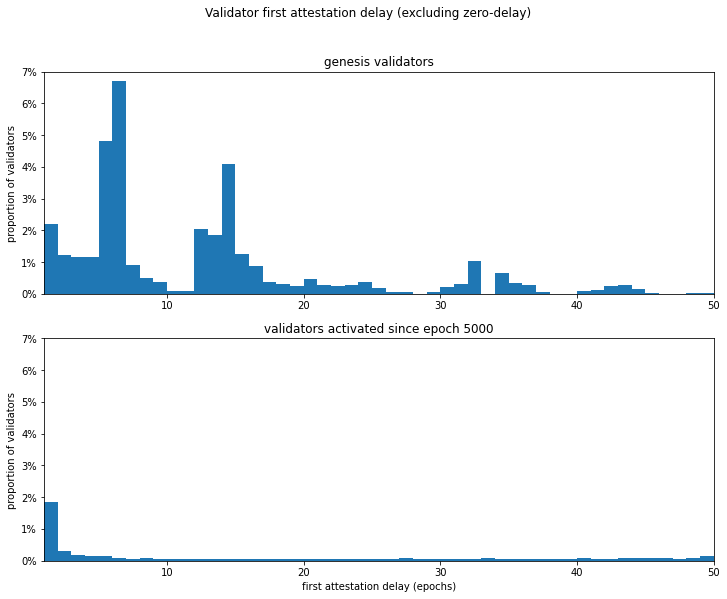

In [15]:
# calculate and plot first attestation delay

genesis_delay = []
post5000_delay = []
for validator in validators:
    delay = validator['first_attestation'] - validator['activation_epoch']
    if validator['activation_epoch'] == 0:
        genesis_delay.append(delay)
    else:
        genesis_delay.append(None)
    if validator['activation_epoch'] >= 5000:
        post5000_delay.append(delay)
    else:
        post5000_delay.append(None)
        
delay_data = pd.DataFrame({'genesis':genesis_delay, 'post5000':post5000_delay})

genesis_validators   = [v for v in validators if v['activation_epoch'] == 0]
n_genesis_validators = len(genesis_validators)
n_genesis_live       = sum([v['first_attestation'] != -1 for v in genesis_validators])
n_genesis_prompt     = sum([v['first_attestation'] ==  0 for v in genesis_validators])
n_genesis_late       = sum([v['first_attestation'] >  50 for v in genesis_validators])

print("Genesis validators")
print("------------------")
print(f"Number of validators: {n_genesis_validators} "
      f"(of which {100*n_genesis_live/n_genesis_validators:.1f}% non-absent)\n"
      f"{100*n_genesis_prompt/n_genesis_validators:.1f}% "
      f"of non-absent genesis validators attested successfully in their first active epoch.\n"
      f"{100*n_genesis_late/n_genesis_validators:.1f}% "
      f"of non-absent genesis validators first attested more than 50 epochs late.\n")

post5000_validators   = [v for v in validators if v['activation_epoch'] >= 5000]
n_post5000_validators = len(post5000_validators)
n_post5000_live       = sum([v['first_attestation'] != -1 for v in post5000_validators])
n_post5000_prompt     = sum([v['first_attestation'] == v['activation_epoch'] for v in post5000_validators])
n_post5000_late       = sum([v['first_attestation']  - v['activation_epoch'] > 50 for v in post5000_validators])


print("Validators activated since epoch 5000")
print("-------------------------------------")
print(f"Number of validators: {n_post5000_validators} "
      f"(of which {100*n_post5000_live/n_post5000_validators:.1f}% non-absent)\n"
      f"{100*n_post5000_prompt/n_post5000_validators:.1f}% "
      f"of non-absent validators attested successfully in their first active epoch.\n"
      f"{100*n_post5000_late/n_post5000_live:.1f}% "
      f"of non-absent validators first attested more than 50 epochs late.\n")

fig, axs = plt.subplots(2, figsize=(12,9))
fig.suptitle('Validator first attestation delay (excluding zero-delay)')

delay_data['genesis'].plot.hist(density=True, bins=50, range=(0,50), ax=axs[0])
axs[0].set_title('genesis validators')
axs[0].set_xlabel('')
axs[0].set_ylabel('proportion of validators')
axs[0].set_xlim(1,50)
axs[0].set_ylim(0,0.07)
axs[0].yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))

delay_data['post5000'].plot.hist(density=True, bins=50, range=(0,50), ax=axs[1])
axs[1].set_title('validators activated since epoch 5000')
axs[1].set_xlabel('first attestation delay (epochs)')
axs[1].set_ylabel('proportion of validators')
axs[1].set_xlim(1,50)
axs[1].set_ylim(0,0.07)
axs[1].yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0));

# Conclusions
Much of the analysis conducted so far rests on an important assumption — that validators who were dormant, absent or abandoned were so because the people responsible for them weren't properly incentivised. As a testnet with no value at stake, Medalla relies to a significant extent on participants acting non-maliciously, and on being reliable for the good of the network. This was always going to be a significant weakness of Medalla.

Without evidence to support an alternative explanation for this validator behaviour (such as significant numbers of users complaining they are unable to join or remain synchronised to the network), it seems reasonable to conclude that dormant/absent/abandoned validators are largely the result of apathy resulting from a lack of real-value incentivsiation. It therefore makes sense to try and exclude these types of validators from our analysis, since very few such validators would be expected to exist on a properly incentivised network.

With this in mind, this analysis seems to show that beacon chain protocol and the clients that implement it are able to achieve consistently high participation rates, which we should expect will be even higher once real value is on the line. It seems likely that this difference will be enough to push genesis participation up from 60% to the 66% required for immediate finality, recent results from Zinken testnet are encouraging in this regard. 

Still, the genesis period remains a period of greater risk, and every effort should be made to ensure the genesis validators are ready before proceeding. For example, last-minute client releases should be considered as potential grounds for "stopping the timer" on genesis delay. To prevent this from being necessary, all clients should ensure they have their mainnet configurations released before the deposit contract goes live, and should avoid new releases in between deposit contract launch and genesis unless critical.

Overall, this data is encouraging from the perspective of demonstrating the feasability of a beacon chain under mainnet-like loads, at least in terms of numbers of validators, can run smoothly. However, it's important to remember that the beacon chain in its initial form does not support any data or execution shards, which will add additional load to the protocol in future. 